## Import necessary modules
Run this cell before running any other cells

In [117]:
!pip install bleak colorama



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [118]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Printing and Logging
## Printing
You can use the **print()** function in Python to print messages to the screen. <br>
The message can be a string, or any other object, the object will be converted into a string before it is written to the screen. <br>

## Logging
You could use the logging module that is setup in *utils.py*. <br>
It prints to both your screen (standard output) as well as to log files (*ble.log*) in the *logs* directory. <br>
This is the recommended way to output messages, since the log files can help with debugging. <br>
The logging module also provides different log levels as shown below, each formatted with a different color for increased visibility. <br>

__**NOTE**__: You may notice that the DEBUG message is not printed to the screen but is printed in the log file. This is because the logging level for the screen is set to INFO and for the file is set to DEBUG. You can change the default log levels in *utils.py* (**STREAM_LOG_LEVEL** and **FILE_LOG_LEVEL**). 

## Formatting output
To format your strings, you may use %-formatting, str.format() or f-strings. <br>
The most "pythonic" way would be to use f-strings. [Here](https://realpython.com/python-f-strings/) is a good tutorial on f-strings. <br>

In [119]:
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")


2026-02-10 16:27:11,711 | INFO     |: info
2026-02-10 16:27:11,712 | WARNING  |: warning
2026-02-10 16:27:11,713 | ERROR    |: error
2026-02-10 16:27:11,713 | CRITICAL |: critical


<hr>

# BLE
## ArtemisBLEController
The class **ArtemisBLEController** (defined in *ble.py*) provides member functions to handle various BLE operations to send and receive data to/from the Artemis board, provided the accompanying Arduino sketch is running on the Artemis board. <br>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Functions</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">reload_config()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Reload changes made in <em>connection.yaml.</em></span></th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">connect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Connect to the Artemis board, whose MAC address is specified in <em>connection.yaml</em>.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">disconnect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Disconnect from the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">is_connected()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Return a boolean indicating whether your controller is connected to the Artemis board or not.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">send_command(cmd_type, data)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Send the command <strong>cmd_type</strong> (integer) with <strong>data</strong> (string) to the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">receive_float(uuid) <br> receive_string(uuid) <br> receive_int(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Read the GATT characteristic (specified by its <strong>uuid</strong>) of type float, string or int. <br> The type of the GATT
            characteristic is determined by the classes BLEFloatCharacteristic, BLECStringCharacteristic or
            BLEIntCharacteristic in the Arduino sketch.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">start_notify(uuid, notification_handler)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Activate notifications on the GATT characteristic (specified by its <strong>uuid</strong>). <br> <strong>notification_handler</strong> is a
            function callback which must accept two inputs; the first will be a uuid string object and the second will
            be the bytearray of the characteristic value.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">bytearray_to_float(byte_array) <br> bytearray_to_string(byte_array) <br> bytearray_to_int(byte_array)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Convert the <strong>bytearray</strong> to float, string or int, respectively. <br> You may use these functions inside your
            notification callback function.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">stop_notify(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Stop notifications on the GATT characteristic (specified by its <strong>uuid</strong>).</span></th>
    </tr>
</table>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Variables</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">uuid</span></th>
        <th style="text-align: left"><span style="font-weight: normal">A dictionary that stores the UUIDs of the various characteristics specified in <em>connection.yaml</em>.</span></th>
    </tr>
</table>

## Configuration
- The MAC address, Service UUID and GATT characteristic UUIDs are defined in the file: *connection.yaml*.
- They should match the UUIDs used in the Arduino sketch.
- The artemis board running the base code should display its MAC address in the serial monitor.
- Update the **artemis_address** in *connection.yaml*, accordingly.
- Make sure to call **ble.reload_config()** or **get_ble_controller()** (which internally calls **reload_config()**) after making any changes to your configuration file.

<hr>

In the below cell, we create an **ArtemisBLEController** object using **get_ble_controller()** (defined in *ble.py*), which creates and/or returns a single instance of **ArtemisBLEController**. <br>
<span style="color:rgb(240,50,50)"> __NOTE__: Do not use the class directly to instantiate an object. </span><br>

In [120]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()


2026-02-10 16:27:11,726 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:95:21:a2:64
2026-02-10 16:27:11,727 | INFO     |: Scanning for device with address: c0:81:95:21:a2:64, service UUID: 1785129f-3b3a-4cf5-a01f-03668e8b12e9
2026-02-10 16:27:21,777 | INFO     |: Found 1 device(s) advertising service 1785129f-3b3a-4cf5-a01f-03668e8b12e9
2026-02-10 16:27:21,778 | INFO     |: Selecting device: AE68F85F-67D4-4FE1-04EC-9F24C2B315FC (name: Artemis BLE)
2026-02-10 16:27:22,751 | INFO     |: Connected to c0:81:95:21:a2:64


## Receive data from the Artemis board

The cell below shows examples of reading different types (as defined in the Arduino sketch) of GATT characteristics.

In [121]:
# Read a float GATT Charactersistic
f = ble.receive_float(ble.uuid['RX_FLOAT'])
print(f)


347.0


In [122]:
# Read a string GATT Charactersistic
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)


END


## Send a command to the Artemis board
Send the PING command and read the reply string from the string characteristic RX_STRING. <br>
__NOTE__: The **send_command()** essentially sends a string data to the GATT characteristic (TX_CMD_STRING). The GATT characteristic in the Arduino sketch is of type BLECStringCharacteristic.

In [123]:
ble.send_command(CMD.PING, "")


In [124]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)


PONG


The cell below shows an example of the SEND_TWO_INTS command. <br> The two values in the **data** are separated by a delimiter "|". <br>
Refer Lab 2 documentation for more information on the command protocol.

In [125]:
ble.send_command(CMD.SEND_TWO_INTS, "2|-6")


The Artemis board should print the two integers to the serial monitor in the ArduinoIDE. 

In [126]:
ble.send_command(CMD.ECHO, "HiHello")
s = ble.receive_string(ble.uuid["RX_STRING"])
print(s)


Robot Says -> HiHello


In [127]:
float_a = 3.14
float_b = 6.28
float_c = 9.52
ble.send_command(CMD.SEND_THREE_FLOATS, f"{float_a}|{float_b}|{float_c}")


In [128]:
ble.send_command(CMD.GET_TIME_MILLIS, "")
s = ble.receive_string(ble.uuid["RX_STRING"])
print(s)


T:410677|84.658


In [129]:
import numpy as np
import asyncio

times = np.array([])
temps = np.array([])

def handle_time(uuid, message):
    global times
    global temps
    
    message_str = message.decode()
    arr = message_str.split("|")
    time_str, temp_str = arr[0], arr[1]
    time = float(time_str.split(":")[1])
    temp = float(temp_str)
    
    times = np.append(times, time)
    temps = np.append(temps, temp)
    

try:
    ble.stop_notify(ble.uuid["RX_STRING"])
except Exception:
    pass 

ble.start_notify(ble.uuid["RX_STRING"], handle_time)

async def await_times():
    global times
    while len(times) < 100:
        await asyncio.sleep(0.1)


In [130]:
import matplotlib.pyplot as plt



In [131]:
times = np.array([])
temps = np.array([])


In [132]:

ble.send_command(CMD.STORE_TIME_MILLIS, "100")

ble.send_command(CMD.SEND_TIME_MILLIS, "")


In [133]:
await await_times()

dts = np.diff(times)

print(f"Fast Times Length: {len(times)}")
print(f"Fast Times Mean: {np.mean(dts)}")
print(f"Fast Times Std: {np.std(dts)}")

print(f"Fast Temps Length: {len(temps)}")
print(f"Fast Temps Mean: {np.mean(temps)}")
print(f"Fast Temps Std: {np.std(temps)}")



Fast Times Length: 100
Fast Times Mean: 0.35353535353535354
Fast Times Std: 0.9672739086766959
Fast Temps Length: 100
Fast Temps Mean: 84.15242999999998
Fast Temps Std: 0.5371144804415539


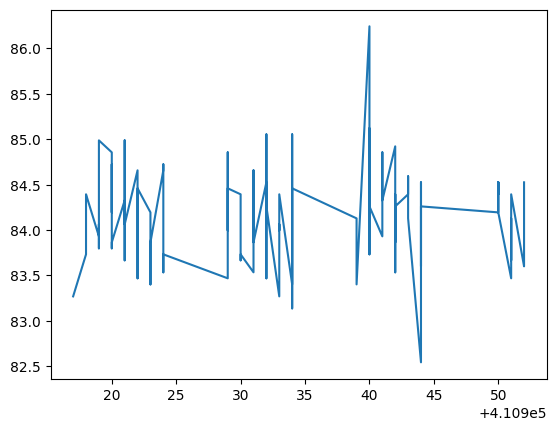

In [134]:
import matplotlib.pyplot as plt

plt.plot(times, temps)
plt.show()


## IMU Circular Buffer Data
Wait for IMU data to accumulate in the circular buffer, then retrieve and plot all 9 channels.

In [144]:
import numpy as np
import asyncio

imu_data = {
    'time': [], 'acc_x': [], 'acc_y': [], 'acc_z': [],
    'gyr_x': [], 'gyr_y': [], 'gyr_z': [],
    'mag_x': [], 'mag_y': [], 'mag_z': [],
}
tof_data = {
    'time': [], 'dist': [],
}
imu_done = False

def handle_sensor_data(uuid, message):
    global imu_data, tof_data, imu_done
    msg = message.decode()
    
    if msg == "END":
        imu_done = True
        return
    
    prefix = msg[0:2]
    parts = msg[2:].split("|")
    
    if prefix == "I:":
        # Parse "I:time|ax|ay|az|gx|gy|gz|mx|my|mz"
        time_val = float(parts[0])
        vals = [float(p) for p in parts[1:]]
        imu_data['time'].append(time_val)
        imu_data['acc_x'].append(vals[0])
        imu_data['acc_y'].append(vals[1])
        imu_data['acc_z'].append(vals[2])
        imu_data['gyr_x'].append(vals[3])
        imu_data['gyr_y'].append(vals[4])
        imu_data['gyr_z'].append(vals[5])
        imu_data['mag_x'].append(vals[6])
        imu_data['mag_y'].append(vals[7])
        imu_data['mag_z'].append(vals[8])
    
    elif prefix == "D:":
        # Parse "D:time|distance_mm"
        time_val = float(parts[0])
        dist_val = float(parts[1])
        tof_data['time'].append(time_val)
        tof_data['dist'].append(dist_val)

try:
    ble.stop_notify(ble.uuid["RX_STRING"])
except Exception:
    pass 

ble.start_notify(ble.uuid["RX_STRING"], handle_sensor_data)


In [145]:
# Wait for IMU data to accumulate, then request the buffer
import time

imu_data = {
    'time': [], 'acc_x': [], 'acc_y': [], 'acc_z': [],
    'gyr_x': [], 'gyr_y': [], 'gyr_z': [],
    'mag_x': [], 'mag_y': [], 'mag_z': [],
}
imu_done = False

ble.send_command(CMD.SEND_IMU_DATA, "")
while not imu_done:
    await asyncio.sleep(0.1)

print(f"Received {len(imu_data['time'])} IMU samples")


CancelledError: 

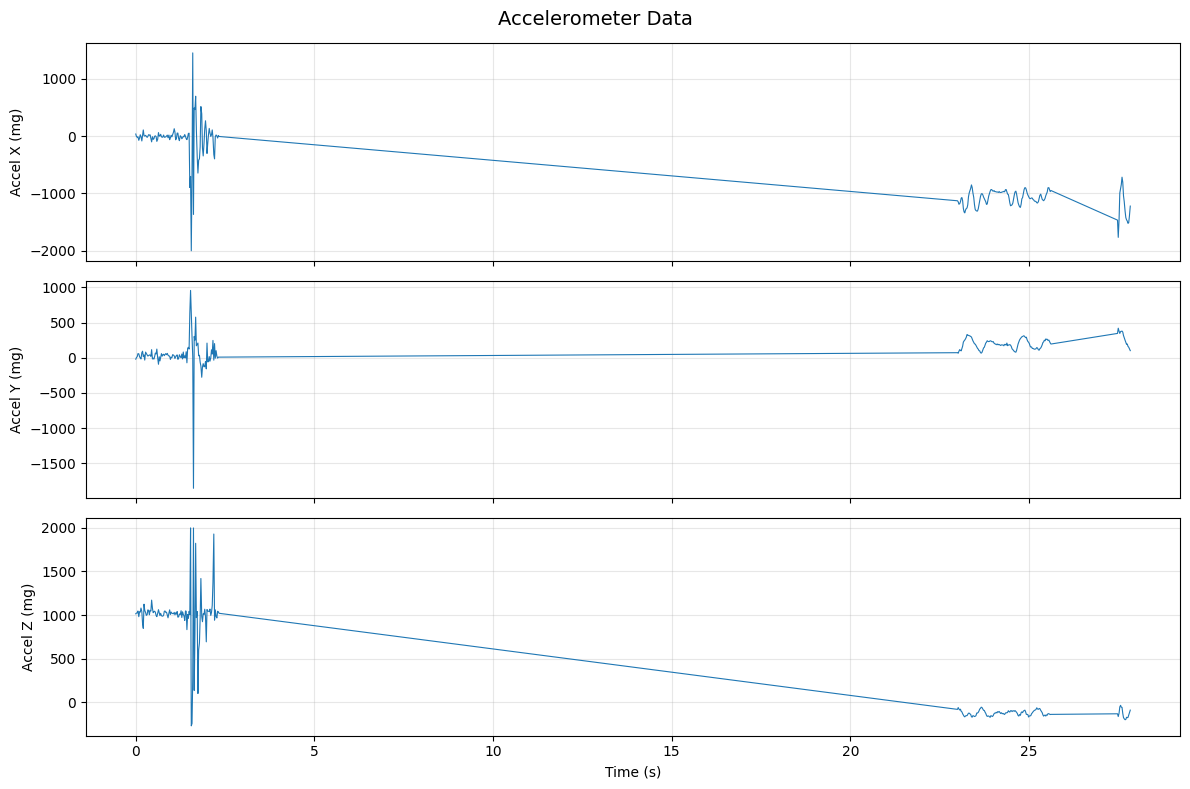

In [ ]:
import matplotlib.pyplot as plt

t = np.array(imu_data['time']) / 1e6  # Convert microseconds to seconds
t = t - t[0]  # Zero-base the time

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Accelerometer Data', fontsize=14)

for ax, key, label in zip(axes, ['acc_x', 'acc_y', 'acc_z'], ['X', 'Y', 'Z']):
    ax.plot(t, imu_data[key], linewidth=0.8)
    ax.set_ylabel(f'Accel {label} (mg)')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()


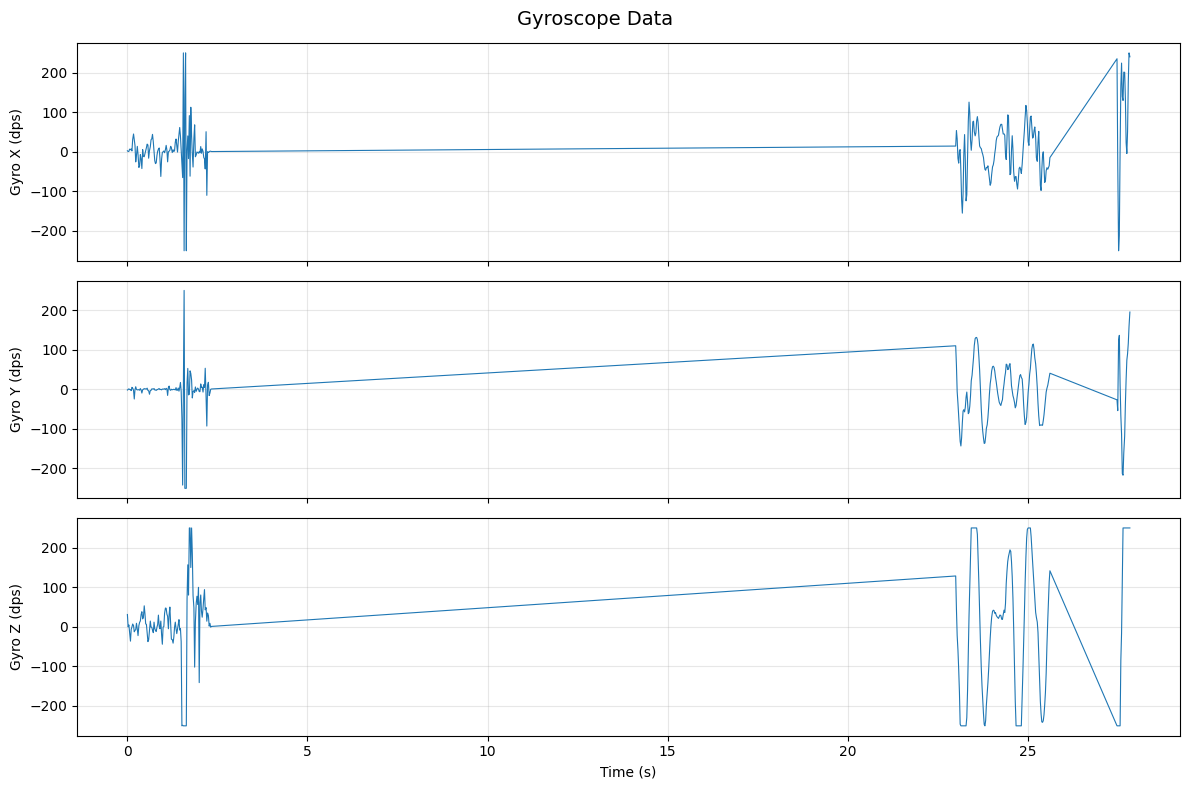

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Gyroscope Data', fontsize=14)

for ax, key, label in zip(axes, ['gyr_x', 'gyr_y', 'gyr_z'], ['X', 'Y', 'Z']):
    ax.plot(t, imu_data[key], linewidth=0.8)
    ax.set_ylabel(f'Gyro {label} (dps)')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()


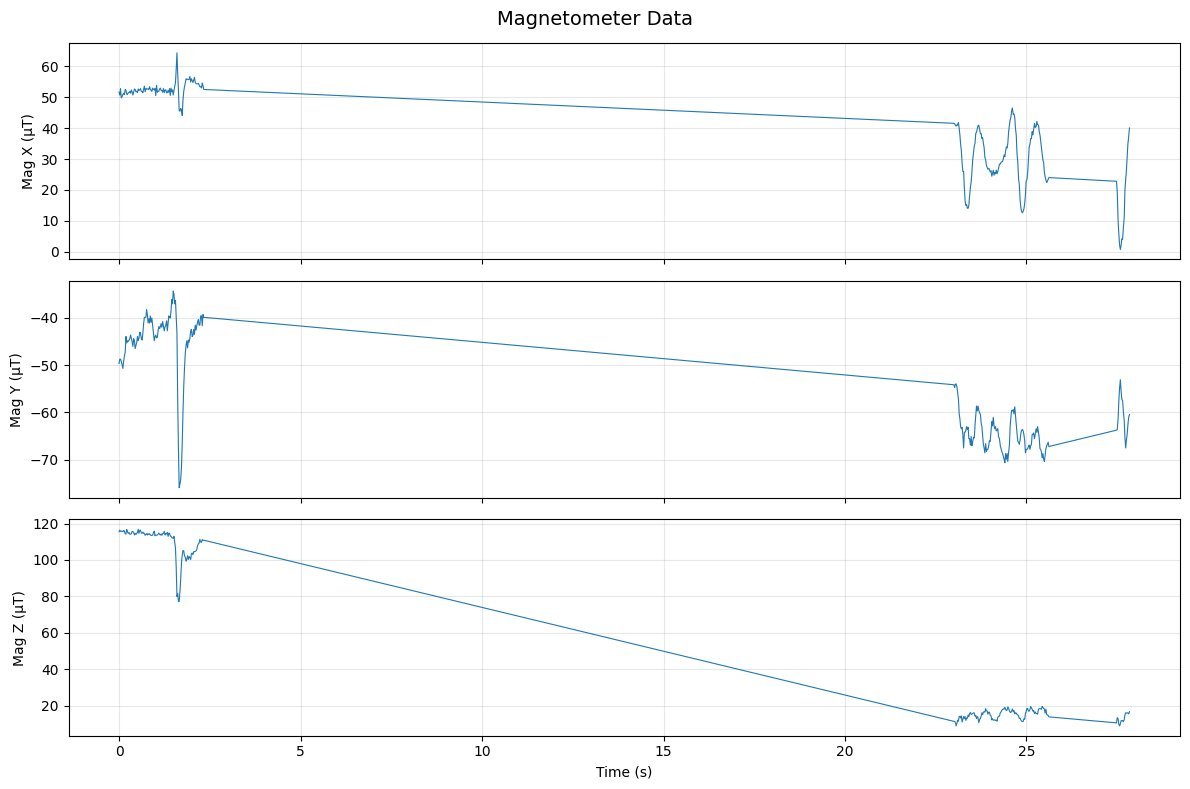

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Magnetometer Data', fontsize=14)

for ax, key, label in zip(axes, ['mag_x', 'mag_y', 'mag_z'], ['X', 'Y', 'Z']):
    ax.plot(t, imu_data[key], linewidth=0.8)
    ax.set_ylabel(f'Mag {label} (µT)')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()


## ToF Circular Buffer Data
Wait for ToF distance data to accumulate, then retrieve and plot.

Received 63 ToF samples


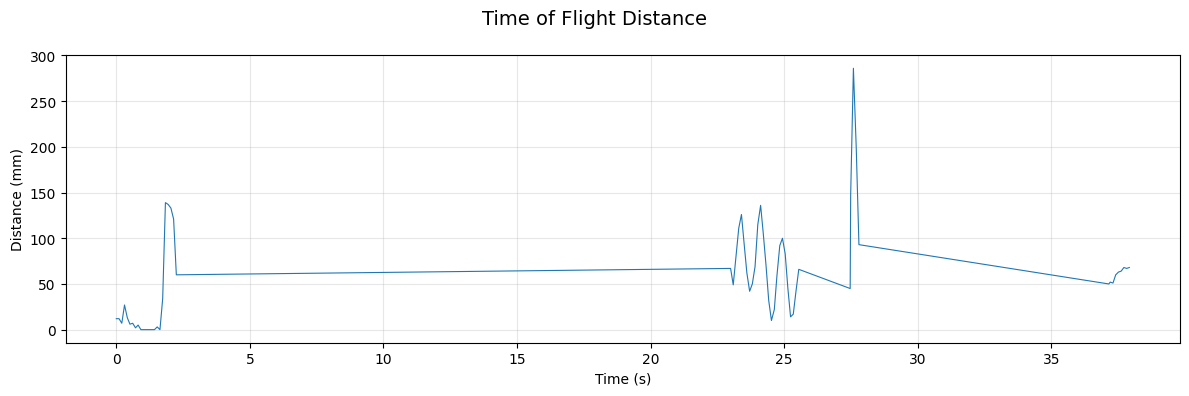

In [ ]:
tof_data = {
    'time': [], 'dist': [],
}
imu_done = False

ble.send_command(CMD.SEND_TOF_DATA, "")
while not imu_done:
    await asyncio.sleep(0.1)

print(f"Received {len(tof_data['time'])} ToF samples")

tof_t = np.array(tof_data['time']) / 1e6  # Convert microseconds to seconds
tof_t = tof_t - tof_t[0]  # Zero-base the time

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle('Time of Flight Distance', fontsize=14)
ax.plot(tof_t, tof_data['dist'], linewidth=0.8)
ax.set_ylabel('Distance (mm)')
ax.set_xlabel('Time (s)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## ToF Accuracy Testing
Switch between short/long mode and collect mean ± std at different distances.
Run the stats cell repeatedly at each distance to build up a table.

In [ ]:
# Switch ToF mode — run ONE of these before collecting samples
# ble.send_command(CMD.TOF_SHORT, "")
ble.send_command(CMD.TOF_LONG, "")


In [ ]:
# Collect ToF stats at a known distance
# Set this to your measured ground-truth distance (mm)
true_distance_mm = 300

import time

# Let buffer fill with fresh samples
time.sleep(2)

# Request stats from the board
tof_stats = None

def handle_tof_stats(uuid, message):
    global tof_stats
    msg = message.decode()
    if msg.startswith("S:"):
        parts = msg[2:].split("|")
        tof_stats = {
            'n': int(parts[0]),
            'mean': float(parts[1]),
            'std': float(parts[2]),
        }

ble.stop_notify(ble.uuid["RX_STRING"])
ble.start_notify(ble.uuid["RX_STRING"], handle_tof_stats)

ble.send_command(CMD.TOF_STATS, "")
while tof_stats is None:
    await asyncio.sleep(0.1)

print(f"n={tof_stats['n']}, mean={tof_stats['mean']:.1f} mm, std={tof_stats['std']:.2f} mm")
print(f"Error from {true_distance_mm} mm: {tof_stats['mean'] - true_distance_mm:.1f} mm")

# Append to results table
if 'tof_results' not in dir():
    tof_results = []
tof_results.append({
    'true_mm': true_distance_mm,
    'mean_mm': tof_stats['mean'],
    'std_mm': tof_stats['std'],
    'n': tof_stats['n'],
})


CancelledError: 

In [ ]:
# Display results table
import matplotlib.pyplot as plt
import numpy as np

if tof_results:
    trues = [r['true_mm'] for r in tof_results]
    means = [r['mean_mm'] for r in tof_results]
    stds  = [r['std_mm'] for r in tof_results]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.errorbar(trues, means, yerr=stds, fmt='o', capsize=5, label='Measured')
    ax.plot([min(trues), max(trues)], [min(trues), max(trues)], 'k--', alpha=0.5, label='Ideal')
    ax.set_xlabel('True Distance (mm)')
    ax.set_ylabel('Measured Distance (mm)')
    ax.set_title('ToF Sensor Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"{'True (mm)':>10} {'Mean (mm)':>10} {'Std (mm)':>10} {'Error (mm)':>10} {'N':>5}")
    print('-' * 50)
    for r in tof_results:
        err = r['mean_mm'] - r['true_mm']
        print(f"{r['true_mm']:>10} {r['mean_mm']:>10.1f} {r['std_mm']:>10.2f} {err:>10.1f} {r['n']:>5}")
else:
    print('No results yet — run the stats cell above first.')


## Disconnect

In [ ]:
# Disconnect
# ble.disconnect()
